![](Images/2022-12-06-18-02-47.png)

## We want to connect the points in a loop
* U_i_j    = the connection between point i and point j is a binary variable exist or not
* D_i_j    = the Distance between point i and point j  => obtaining it from point locations
* flow_i_j = The demand between point i and point j    =>
* G_i      = Generation (Production)of node i          => assume any thing
* L_i      = attraction of node i                      => assume andy thing
* M        = Number of points
* c = j



In [1]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
import random

In [12]:
# initialize the model
model = pyo.AbstractModel()

# # initialize the parameters and the variables
model.M = pyo.Param(mutable=True, default=8)
model.I = pyo.RangeSet(1, model.M)
model.J = pyo.Set(initialize=model.I)

## Initiate points randomly
def initval(model, i):
    return random.uniform(0.001,1)
model.x_loc = pyo.Param(model.I, within=pyo.NonNegativeReals, initialize=initval, mutable=True)
model.y_loc = pyo.Param(model.I, within=pyo.NonNegativeReals, initialize=initval, mutable=True)

def dis_rule(model, i, j):
    return pyo.sqrt((model.x_loc[i] - model.x_loc[j])**2 + (model.y_loc[i] - model.y_loc[j])**2)
model.D = pyo.Param(model.I, model.J, within=pyo.NonNegativeReals, initialize=dis_rule, mutable=True)

model.U = pyo.Var(model.I, model.J, within=pyo.Binary, initialize=1)
model.flow = pyo.Var(model.I, model.J, within=pyo.NonNegativeReals)
model.G = pyo.Var(bounds=(0, model.M), within=pyo.NonNegativeReals)


# # # Constraint Declarations
def con_1_rule(model, i):
    if i == 1:
        return model.G -0.1 ==sum(model.flow[i,j] - model.flow[j,i] if i!=j else 0 for j in model.J)
    else:
        return      0  -0.1 ==sum(model.flow[i,j] - model.flow[j,i]  if i!=j else 0 for j in model.J)
model.c1 = pyo.Constraint(model.I, rule = con_1_rule)

def con_2_rule(model, i, j):
    return model.flow[i,j] <= model.U[i,j]  *model.M   # flow = number of connected points equal the number of points or less
model.c2 = pyo.Constraint(model.I, model.J, rule=con_2_rule)

def con_3_rule(model, i):
    return sum(model.U[i,j] for j in model.J)  == 1
model.c3 = pyo.Constraint(model.I, rule=con_3_rule)

def con_4_rule(model, j):
    return sum(model.U[i,j] for i in model.I)  == 1
model.c4 = pyo.Constraint(model.J, rule=con_4_rule)

def OF_rule(model):
    return np.sum(model.U[i,j] * model.D[i,j] for i in model.I for j in model.J)
model.OF = pyo.Objective(rule= OF_rule, sense=pyo.minimize)

# Define the solver
solver = pyo.SolverFactory('glpk')
instance = model.create_instance()
results = solver.solve(instance)

# write the results
results.write()

    mutable Param).  The linkage between this RangeSet and the original source
    data will be broken, so updating the data value in the future will not be
    reflected in this RangeSet.  To suppress this warning, explicitly convert
    the source data to a constant type (e.g., float, int, or immutable Param)
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 3.14095802595076
  Upper bound: 3.14095802595076
  Number of objectives: 1
  Number of constraints: 89
  Number of variables: 130
  Number of nonzeros: 370
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ---------------------------------------------------------

C:\Users\20100\AppData\Local\Temp\ipykernel_6336\3563097510.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(model.U[i,j] * model.D[i,j] for i in model.I for j in model.J)


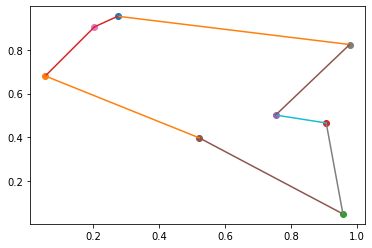

In [13]:
for i in instance.I:
    plt.scatter(pyo.value(instance.x_loc[i]), pyo.value(instance.y_loc[i]))
    plt.plot(pyo.value(instance.x_loc[i]), pyo.value(instance.y_loc[i]))
    for j in  instance.J:
        if i != j:
            if pyo.value(instance.U[i, j])== 1:
                plt.plot( [ pyo.value(instance.x_loc[i]), pyo.value(instance.x_loc[j]) ], [ pyo.value(instance.y_loc[i]), pyo.value(instance.y_loc[j]) ])
